# ALS collaborative method evaluation

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import BaselineOnly, Dataset, Reader, SVD
from surprise.model_selection import train_test_split

import recmetrics

In [170]:
ratings = pd.read_csv('../Datasets/final_sample_user_ratings_corrected.csv')
# drop the rows with NaN values 
ratings.dropna(inplace=True)

ratings['user_id']=ratings['user_id'].astype(int)
ratings['destination_id']=ratings['destination_id'].astype(int)

print(ratings.head())
ratings.shape

   user_id  destination_id       destination_name  rating
0        0               1  Phewa Tal (Fewa Lake)     5.0
1        0               2              Sarangkot     5.0
2        0               3   Swayambhunath Temple     5.0
3        0               4              Poon Hill     5.0
4        0               5           Peace Temple     5.0


(6169, 4)

In [171]:
ratings.reset_index(drop=True,inplace=True)
ratings

,user_id,destination_id,destination_name,rating
0,0,1,Phewa Tal (Fewa Lake),5.0
1,0,2,Sarangkot,5.0
2,0,3,Swayambhunath Temple,5.0
3,0,4,Poon Hill,5.0
4,0,5,Peace Temple,5.0
...,...,...,...,...
6164,249,257,Guru Lhakhang Monastery,5.0
6165,249,275,Kashmiri Mosque,4.0
6166,249,277,Manimandap Pati,3.0
6167,249,289,Sundarijal Water Falls,3.0


In [172]:
#only consider ratings from users who have rated over n movies
n=10
users = ratings["user_id"].value_counts()
users = users[users>n].index.tolist()

In [173]:
# ratings = ratings.query('user_id in @users')
# print(ratings.shape)
# ratings.head(3)

In [174]:
# we won't be working with the destination_name column 
# so better to leave that one out too 
ratings.drop(['destination_name'],axis=1,inplace=True)
ratings.head()

,user_id,destination_id,rating
0,0,1,5.0
1,0,2,5.0
2,0,3,5.0
3,0,4,5.0
4,0,5,5.0


## Get destination features

In [175]:
destinations=pd.read_csv("reindexed_nepal_destinations_with_added_genre_columns.csv")
destinations

,dest_id,title,genre,latitude,longitude,img_url,genre_updated,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,history:art_and_architecture:religious,27.721506,85.359809,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),nature,28.211627,83.932296,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,nature,28.244376,83.944564,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,history:art_and_architecture:religious,27.714930,85.288146,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
4,4,Poon Hill,nature,28.400195,83.671789,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,437,Travel Maker South Asia,art_and_architecture:religious,27.713420,85.311246,NaN,"['art_and_architecture', 'religious']",False,True,False,False,False,False,False,False,True
438,438,Nepal Alibaba Treks & Tours Pvt Ltd,history,27.737544,85.302841,NaN,['history'],True,False,False,False,False,False,False,False,False
439,439,Alpine Ramble Treks,history,27.719162,85.306492,NaN,['history'],True,False,False,False,False,False,False,False,False
440,440,Info Nepal Treks and Expedition,history:art_and_architecture:entertainment,27.716730,85.307607,NaN,"['history', 'art_and_architecture', 'entertain...",True,True,False,False,True,False,False,False,False


In [176]:
# destinations=destinations.drop(['avg_rating','voted_by','genre','latitude','longitude'],axis=1)
# destinations.head()

## Long Tail Plot Example

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


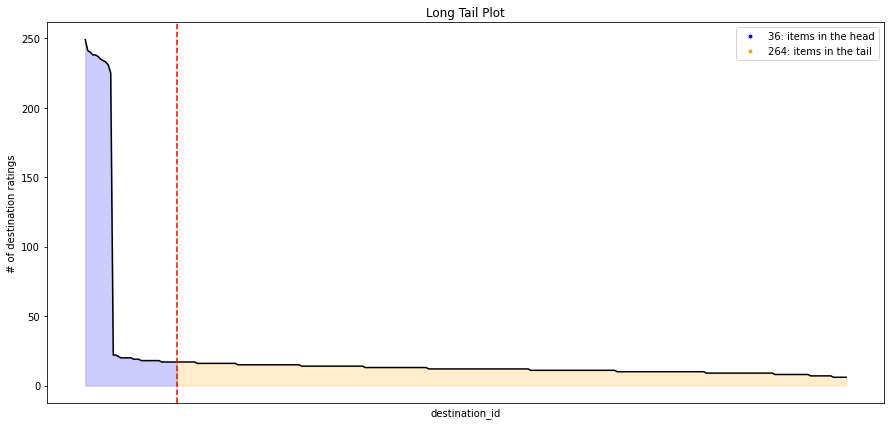

In [177]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="destination_id", 
             interaction_type="destination ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a als approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

## Format data for Surprise

In [178]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'destination_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [179]:
print(data)

## Train als Recommender

In [180]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo1 = BaselineOnly(bsl_options=bsl_options)
algo2 = SVD()
algo1.fit(trainset)
algo2.fit(trainset)

Using ALS
Estimating biases using als...


## Make predictions on als test set

In [181]:
test1 = algo1.test(testset)
test1 = pd.DataFrame(test1)
test1.drop("details", inplace=True, axis=1)
test1.columns = ['user_id', 'destination_id', 'actual', 'als_predictions']
test1.head()
test1

,user_id,destination_id,actual,als_predictions
0,131,9,5.0,4.228355
1,158,153,5.0,3.804938
2,89,267,5.0,4.328524
3,230,242,3.0,2.911250
4,69,129,3.0,3.246964
...,...,...,...,...
1229,20,5,5.0,4.147449
1230,210,160,3.0,3.197781
1231,204,97,3.0,3.511972
1232,32,0,4.0,5.000000


In [182]:
test2 = algo2.test(testset)
test2 = pd.DataFrame(test2)
test2.drop("details", inplace=True, axis=1)
test2.columns = ['user_id', 'destination_id', 'actual', 'svd_predictions']
test2.head()
test2

,user_id,destination_id,actual,svd_predictions
0,131,9,5.0,4.218066
1,158,153,5.0,3.988016
2,89,267,5.0,4.244168
3,230,242,3.0,2.943732
4,69,129,3.0,3.254812
...,...,...,...,...
1229,20,5,5.0,4.204538
1230,210,160,3.0,2.963172
1231,204,97,3.0,3.301409
1232,32,0,4.0,4.954865


In [183]:
merged_test=test1
merged_test['svd_predictions']=test2['svd_predictions']
merged_test

,user_id,destination_id,actual,als_predictions,svd_predictions
0,131,9,5.0,4.228355,4.218066
1,158,153,5.0,3.804938,3.988016
2,89,267,5.0,4.328524,4.244168
3,230,242,3.0,2.911250,2.943732
4,69,129,3.0,3.246964,3.254812
...,...,...,...,...,...
1229,20,5,5.0,4.147449,4.204538
1230,210,160,3.0,3.197781,2.963172
1231,204,97,3.0,3.511972,3.301409
1232,32,0,4.0,5.000000,4.954865


## Evaluate model with MSE and RMSE

In [184]:
print("MSE (ALS): ", recmetrics.mse(test1.actual, test1.als_predictions))
print("MSE (SVD): ", recmetrics.mse(test2.actual, test2.svd_predictions))

print("RMSE (ALS): ", recmetrics.rmse(test1.actual, test1.als_predictions))
print("RMSE (SVD): ", recmetrics.rmse(test2.actual, test2.svd_predictions))

MSE (ALS):  0.5738996613208351
MSE (SVD):  0.5596876181810694
RMSE (ALS):  0.7575616551283698
RMSE (SVD):  0.7481227293573357


In [185]:
#create model (matrix of predicted values)
als_model = test1.pivot_table(index='user_id', columns='destination_id', values='als_predictions').fillna(0)
svd_model = test2.pivot_table(index='user_id', columns='destination_id', values='svd_predictions').fillna(0)

In [186]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [187]:
#get example prediction
# get_users_predictions(23, 10, cf_model)

In [188]:
test1 = test1.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})
test2 = test2.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})

In [189]:
test1 = test1.set_index("user_id")
test2 = test2.set_index("user_id")

In [190]:
# make recommendations for all members in the test data
als_recs = [] = []
for user in test1.index:
    cf_predictions = get_users_predictions(user, 10, als_model)
    als_recs.append(cf_predictions)
        
test1['als_predictions'] = als_recs

In [191]:
# make recommendations for all members in the test data ( for svd )
svd_recs = [] = []
for user in test2.index:
    cf_predictions = get_users_predictions(user, 10, svd_model)
    svd_recs.append(cf_predictions)
        
test2['svd_predictions'] = svd_recs
test2['als_predictions'] = als_recs

In [192]:
test1

,actual,als_predictions
user_id,,
0,"[185, 3, 55]","[3, 55, 185, 195, 202, 201, 200, 199, 198, 196]"
1,"[5, 6, 7, 8, 223]","[8, 223, 6, 5, 7, 0, 195, 202, 201, 200]"
2,"[1, 4, 292, 10, 119]","[1, 4, 10, 119, 292, 194, 201, 200, 199, 198]"
3,"[3, 6, 7, 169, 49]","[3, 6, 7, 49, 169, 192, 191, 190, 193, 194]"
4,"[0, 96, 3, 4, 8, 147]","[0, 4, 8, 3, 96, 147, 191, 192, 190, 193]"
...,...,...
245,"[273, 3, 6, 7]","[3, 6, 7, 273, 0, 202, 201, 200, 199, 198]"
246,"[0, 131, 55]","[0, 131, 55, 196, 202, 201, 200, 199, 198, 195]"
247,"[1, 5, 6, 232, 8, 10, 173]","[1, 10, 8, 6, 5, 173, 232, 196, 203, 202]"


In [193]:
test2

,actual,svd_predictions,als_predictions
user_id,,,
0,"[185, 3, 55]","[3, 55, 185, 195, 202, 201, 200, 199, 198, 196]","[3, 55, 185, 195, 202, 201, 200, 199, 198, 196]"
1,"[5, 6, 7, 8, 223]","[8, 223, 6, 5, 7, 0, 195, 202, 201, 200]","[8, 223, 6, 5, 7, 0, 195, 202, 201, 200]"
2,"[1, 4, 292, 10, 119]","[1, 4, 10, 119, 292, 194, 201, 200, 199, 198]","[1, 4, 10, 119, 292, 194, 201, 200, 199, 198]"
3,"[3, 6, 7, 169, 49]","[6, 3, 7, 49, 169, 192, 191, 190, 193, 194]","[3, 6, 7, 49, 169, 192, 191, 190, 193, 194]"
4,"[0, 96, 3, 4, 8, 147]","[0, 8, 4, 96, 3, 147, 191, 192, 190, 193]","[0, 4, 8, 3, 96, 147, 191, 192, 190, 193]"
...,...,...,...
245,"[273, 3, 6, 7]","[6, 7, 3, 273, 0, 202, 201, 200, 199, 198]","[3, 6, 7, 273, 0, 202, 201, 200, 199, 198]"
246,"[0, 131, 55]","[0, 131, 55, 196, 202, 201, 200, 199, 198, 195]","[0, 131, 55, 196, 202, 201, 200, 199, 198, 195]"
247,"[1, 5, 6, 232, 8, 10, 173]","[1, 10, 5, 8, 6, 173, 232, 196, 203, 202]","[1, 10, 8, 6, 5, 173, 232, 196, 203, 202]"


## Confusion Matrix

In [194]:
actual1 = test1.actual.values.tolist()
actual2 = test2.actual.values.tolist()
als_predictions = test1.als_predictions.values.tolist()
svd_predictions = test2.svd_predictions.values.tolist()
# print(actual)
# print(cf_predictions)

In [195]:
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import confusion_matrix

In [196]:
# a=MultiLabelBinarizer().fit_transform(actual)
# a

In [197]:
# b=MultiLabelBinarizer().fit_transform(cf_predictions)
# b

In [198]:
# recmetrics.make_confusion_matrix(actual,cf_predictions)
# confusion_matrix(a.argmax(axis=1), b.argmax(axis=1))

In [199]:
# recmetrics.make_confusion_matrix(a.argmax(axis=1), b.argmax(axis=1))

# Recall

In [200]:
als_mark = []
for K in np.arange(1, 11):
    als_mark.extend([recmetrics.mark(actual1, als_predictions, k=K)])

print(als_mark)

[0.24743375311557128, 0.46180965499147314, 0.6534582841401023, 0.7927653154925882, 0.885584743539289, 0.9445198740653288, 0.9772842056932967, 0.992929292929293, 0.996694214876033, 0.9986225895316805]


In [201]:
svd_mark = []
for K in np.arange(1, 11):
    svd_mark.extend([recmetrics.mark(actual2, svd_predictions, k=K)])

print(svd_mark)

[0.24743375311557128, 0.46180965499147314, 0.6534582841401023, 0.7927653154925882, 0.885584743539289, 0.9445198740653288, 0.9772842056932967, 0.992929292929293, 0.996694214876033, 0.9986225895316805]


# Mark Plot

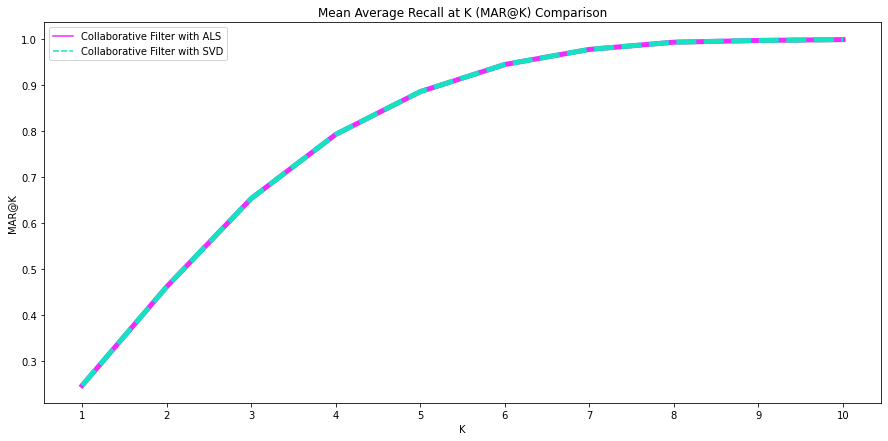

In [202]:
mark_scores = [als_mark,svd_mark]
index = range(1,10+1)
names = ['Collaborative Filter with ALS','Collaborative Filter with SVD']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [203]:
import ml_metrics as metrics
# for MAPK scpre
als_mapk = []
svd_mapk = [] 
for K in np.arange(1, 11):
    als_mapk.extend([metrics.mapk(actual1, als_predictions, k=K)])
    svd_mapk.extend([metrics.mapk(actual2, svd_predictions, k=K)])
print(als_mapk)
print(svd_mapk)
# print(actual)
# print(cf_predictions)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


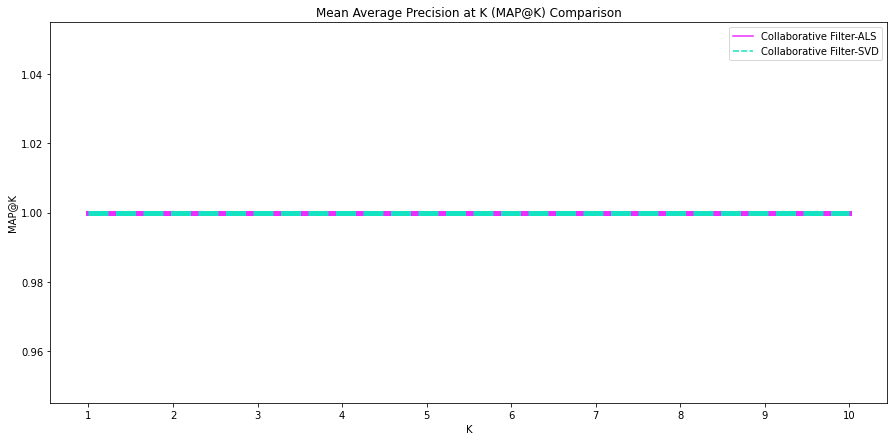

In [204]:
# generate a mapk plot
mapk_scores = [als_mapk,svd_mapk]
index = range(1,10+1)
names = ['Collaborative Filter-ALS','Collaborative Filter-SVD']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

# Prediction Coverage

In [205]:
catalog = ratings.destination_id.unique().tolist()
als_coverage = recmetrics.prediction_coverage(als_recs, catalog)
svd_coverage = recmetrics.prediction_coverage(svd_recs, catalog)
print(als_coverage)
print(svd_coverage)

91.33
91.67


# Coverage Plot

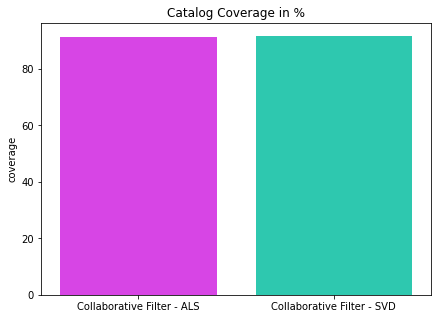

In [206]:
# plot of prediction coverage
coverage_scores = [als_coverage,svd_coverage]
model_names = ['Collaborative Filter - ALS','Collaborative Filter - SVD']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Intra-list Similarity

In [207]:
feature_df=destinations[['history','art_and_architecture','nature','adventure', 'entertainment','health_and_lifestyle',\
                        'food','industries','religious']]

In [208]:
feature_df

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,True,True,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
437,False,True,False,False,False,False,False,False,True
438,True,False,False,False,False,False,False,False,False
439,True,False,False,False,False,False,False,False,False
440,True,True,False,False,True,False,False,False,False


In [209]:
recmetrics.intra_list_similarity(als_predictions, feature_df)

0.5316187932312518

In [210]:
recmetrics.intra_list_similarity(svd_predictions, feature_df)

0.5336882185695199